## Variational autoencoder / GAN / SimCLR
- 2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

cuda
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


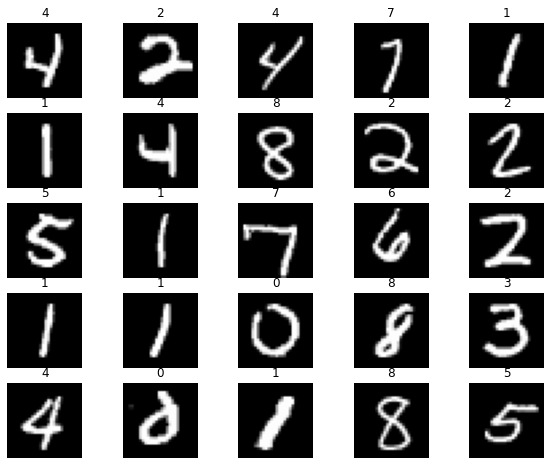

In [2]:
## Preliminaries
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # uncomment this line to run on CPU
print(device)

## Dataset
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True           
)
test_data = torchvision.datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor(),
    download = True
)

label_names=[f'{i}' for i in range(10)]
num_labels = len(label_names)

print(train_data)

## Data Loader
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

look at this https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
consider adding batch normalization to generator and discriminator
consider adding leakyrelu and too discr


In [3]:
## Model definition
#consider using 
class Discriminator(nn.Module):
    def __init__(self, ouput_size=11 ): # 10 for one-hot encoded label + 1 for real/fake
        super().__init__()
        ### Convolutional section
        self.discriminator_cnn = nn.Sequential(
            #normalization layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.LeakyReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.LeakyReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.LeakyReLU(True),
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.discriminator_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.LeakyReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(True),
            nn.Dropout(p=0.5),
            #third linear layer
            nn.Linear(in_features=32, out_features=ouput_size),
            #to restrict ouptut between 0 and 1
            nn.Sigmoid()
        )
    def forward(self, x):
        # Apply convolutions
        x = self.discriminator_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.discriminator_lin(x)
        return x

#consider adding batch normalization to generator 

class Generator(nn.Module):
    def __init__(self, input_size = 12): #10 for one-hot encoded label, + 2 for noise
        super().__init__()
        ### Linear section
        self.generator_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=input_size, out_features=64),
            #nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=128),
            #nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=128, out_features=3*3*32),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.generator_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        ) 
    def forward(self, x):
        # Apply linear layers
        x = self.generator_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.generator_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
        

In [4]:
torch.manual_seed(42)
noise_size = 100

#initialize the discriminator and generator
netD = Discriminator(ouput_size=1).to(device) #1 for real/fake let's start easy
netG = Generator(input_size=noise_size).to(device) #just noise, let's start easy

## testing I/O
#2 element vector with random noise
noise = torch.randn(1, noise_size, device=device) #1 will be batch_size
# one hot encoding of label "3"
label = torch.zeros(1, num_labels, device=device)
label[:, 3] = 1
#concatenate noise and label
input = torch.cat((noise, label), 1)
input = noise #let's start easy
#print input shape
print(f"genrator input shape: {input.shape}")
fake_img = netG(input)
print(f"fake_img shape: {fake_img.shape}")
output = netD(fake_img)
print(f"output shape: {output.shape}") #(1, 11) 10 classes + 1 for real/fake

genrator input shape: torch.Size([1, 100])
fake_img shape: torch.Size([1, 1, 28, 28])
output shape: torch.Size([1, 1])


Idea for training: 


The best idea is to implement the original paper for GANs https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf, let's be real
other useful links:
- https://developers.google.com/machine-learning/gan/loss
- https://github.com/soumith/ganhacks


In [5]:
## Training
#nets
netD = netD.to(device)
netG = netG.to(device)

# learning rate, based on DCGAN paper
g_lr = 0.0002
d_lr = 0.0002
beta1 = 0.5

#loss function
#use minimax loss, basically binary cross entropy
# real_labels = 1, fake_labels = 0
loss_fn = nn.BCELoss() 
real_target = 1
fake_target = 0

#batch of latent vectors to visualize progress
fixed_noise = torch.randn(batch_size,noise_size, device=device)

#optimizers
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=g_lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=d_lr, betas=(beta1, 0.999))

## Training loop
num_epochs = 10
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_img_batch, label_batch) in enumerate(train_dataloader, 0):
        b_size = real_img_batch.size(0) #batch size (can be smaller than batch_size in last batch)
        ## (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with all-real batch
        netD.zero_grad()
        real_img_batch = real_img_batch.to(device)
        # Forward pass real batch through D
        output = netD(real_img_batch)
        # Calculate loss on all-real batch
        target = torch.full((b_size, 1), real_target, device=device, dtype=torch.float)
        errD_real = loss_fn(output, target)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, noise_size, 1,1, device=device)
        # Generate fake image batch with G
        fake_img_batch = netG(noise)
        target.fill_(fake_target)
        # Classify all fake batch with D
        output = netD(fake_img_batch.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, target)
        # Calculate the gradients for this batch
        errD_fake.backward(retain_graph=True) #retain graph for backpropagation
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ## (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        target.fill_(real_target)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake
        output = netD(fake_img_batch)
        # Calculate G's loss based on this output
        errG = loss_fn(output, target)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 300 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/469]	Loss_D: 1.3930	Loss_G: 0.6585	D(x): 0.5174	D(G(z)): 0.5196 / 0.5179
[0/10][50/469]	Loss_D: 1.0407	Loss_G: 1.0889	D(x): 0.5437	D(G(z)): 0.3465 / 0.3409
[0/10][100/469]	Loss_D: 0.2822	Loss_G: 2.3598	D(x): 0.8640	D(G(z)): 0.1106 / 0.1144
[0/10][150/469]	Loss_D: 0.1179	Loss_G: 3.5463	D(x): 0.9529	D(G(z)): 0.0457 / 0.0438
[0/10][200/469]	Loss_D: 0.0916	Loss_G: 3.9412	D(x): 0.9589	D(G(z)): 0.0293 / 0.0327
[0/10][250/469]	Loss_D: 0.1037	Loss_G: 4.1201	D(x): 0.9669	D(G(z)): 0.0293 / 0.0270
[0/10][300/469]	Loss_D: 0.0790	Loss_G: 4.1607	D(x): 0.9771	D(G(z)): 0.0285 / 0.0242
[0/10][350/469]	Loss_D: 0.0342	Loss_G: 4.3097	D(x): 0.9927	D(G(z)): 0.0257 / 0.0214
[0/10][400/469]	Loss_D: 0.0426	Loss_G: 4.4569	D(x): 0.9881	D(G(z)): 0.0270 / 0.0195
[0/10][450/469]	Loss_D: 0.0337	Loss_G: 4.4822	D(x): 0.9905	D(G(z)): 0.0230 / 0.0206
[1/10][0/469]	Loss_D: 0.0575	Loss_G: 4.1021	D(x): 0.9781	D(G(z)): 0.0281 / 0.0282
[1/10][50/469]	Loss_D: 0.0443	Loss_G: 4.3881	D(x): 0.98

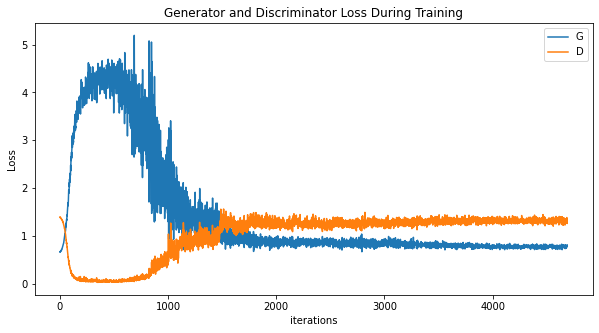

In [6]:
#plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

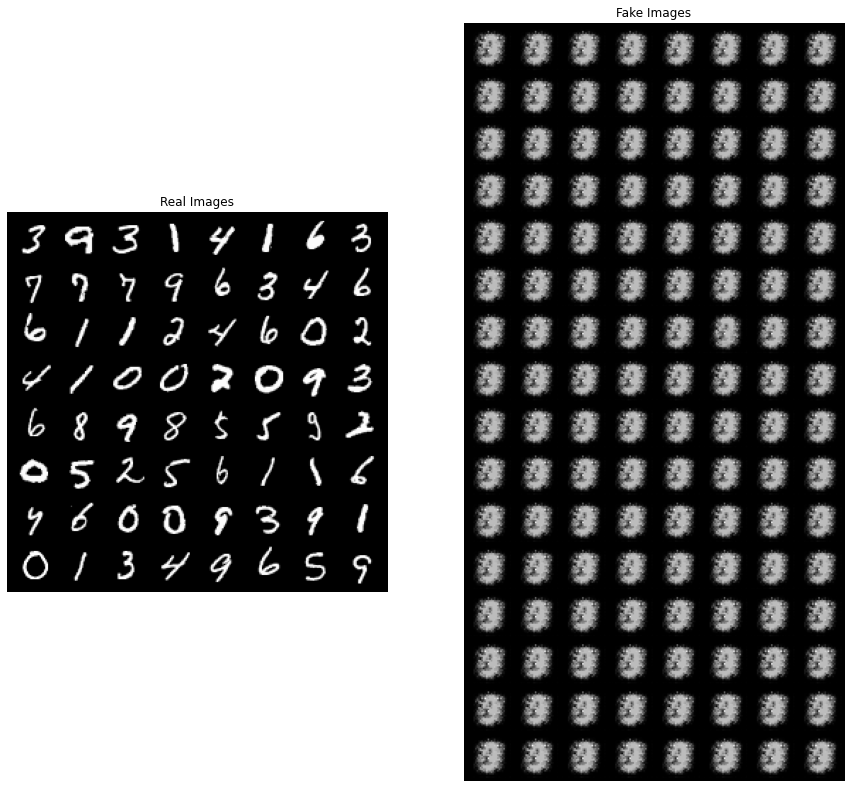

In [7]:
## real vs fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()